In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 17.4 ms


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 7.22 ms


In [2]:
description, train, added_products, label_encoder, encoders = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/train_data.train_data', 'rb'))

time: 52.6 s


In [6]:
jacob_train = pickle.load(open('data/15.Jacobian_similarity_features.train_data', 'rb'))

time: 3.81 s


In [5]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
#     del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

time: 24.6 s


In [8]:
train.shape

(441652, 283)

time: 2.1 ms


In [7]:
jacob_train.shape

(441652, 48)

time: 15.4 s


In [9]:
for col in ['jacob_'+h for h in HEADER[24:]]:
    train[col] = jacob_train[col]

time: 62.6 ms


In [10]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 4.03 s


In [11]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.760182
[1]	train-MAP@7:0.763153
[2]	train-MAP@7:0.765494
[3]	train-MAP@7:0.76594
[4]	train-MAP@7:0.768134
[5]	train-MAP@7:0.768804
[6]	train-MAP@7:0.768976
[7]	train-MAP@7:0.769293
[8]	train-MAP@7:0.769778
[9]	train-MAP@7:0.77012
[10]	train-MAP@7:0.770301
[11]	train-MAP@7:0.770509
[12]	train-MAP@7:0.770885
[13]	train-MAP@7:0.771116
[14]	train-MAP@7:0.771318
[15]	train-MAP@7:0.771544
[16]	train-MAP@7:0.771666
[17]	train-MAP@7:0.771768
[18]	train-MAP@7:0.771897
[19]	train-MAP@7:0.772045
[20]	train-MAP@7:0.772194
[21]	train-MAP@7:0.772291
[22]	train-MAP@7:0.772411
[23]	train-MAP@7:0.772579
[24]	train-MAP@7:0.772719
[25]	train-MAP@7:0.772853
[26]	train-MAP@7:0.772982
[27]	train-MAP@7:0.773039
[28]	train-MAP@7:0.773202
[29]	train-MAP@7:0.773328
[30]	train-MAP@7:0.773494
[31]	train-MAP@7:0.773598
[32]	train-MAP@7:0.773716
[33]	train-MAP@7:0.773858
[34]	train-MAP@7:0.774008
[35]	train-MAP@7:0.774087
[36]	train-MAP@7:0.774184
[37]	train-MAP@7:0.774288
[38]	train-MAP@7:0.77440

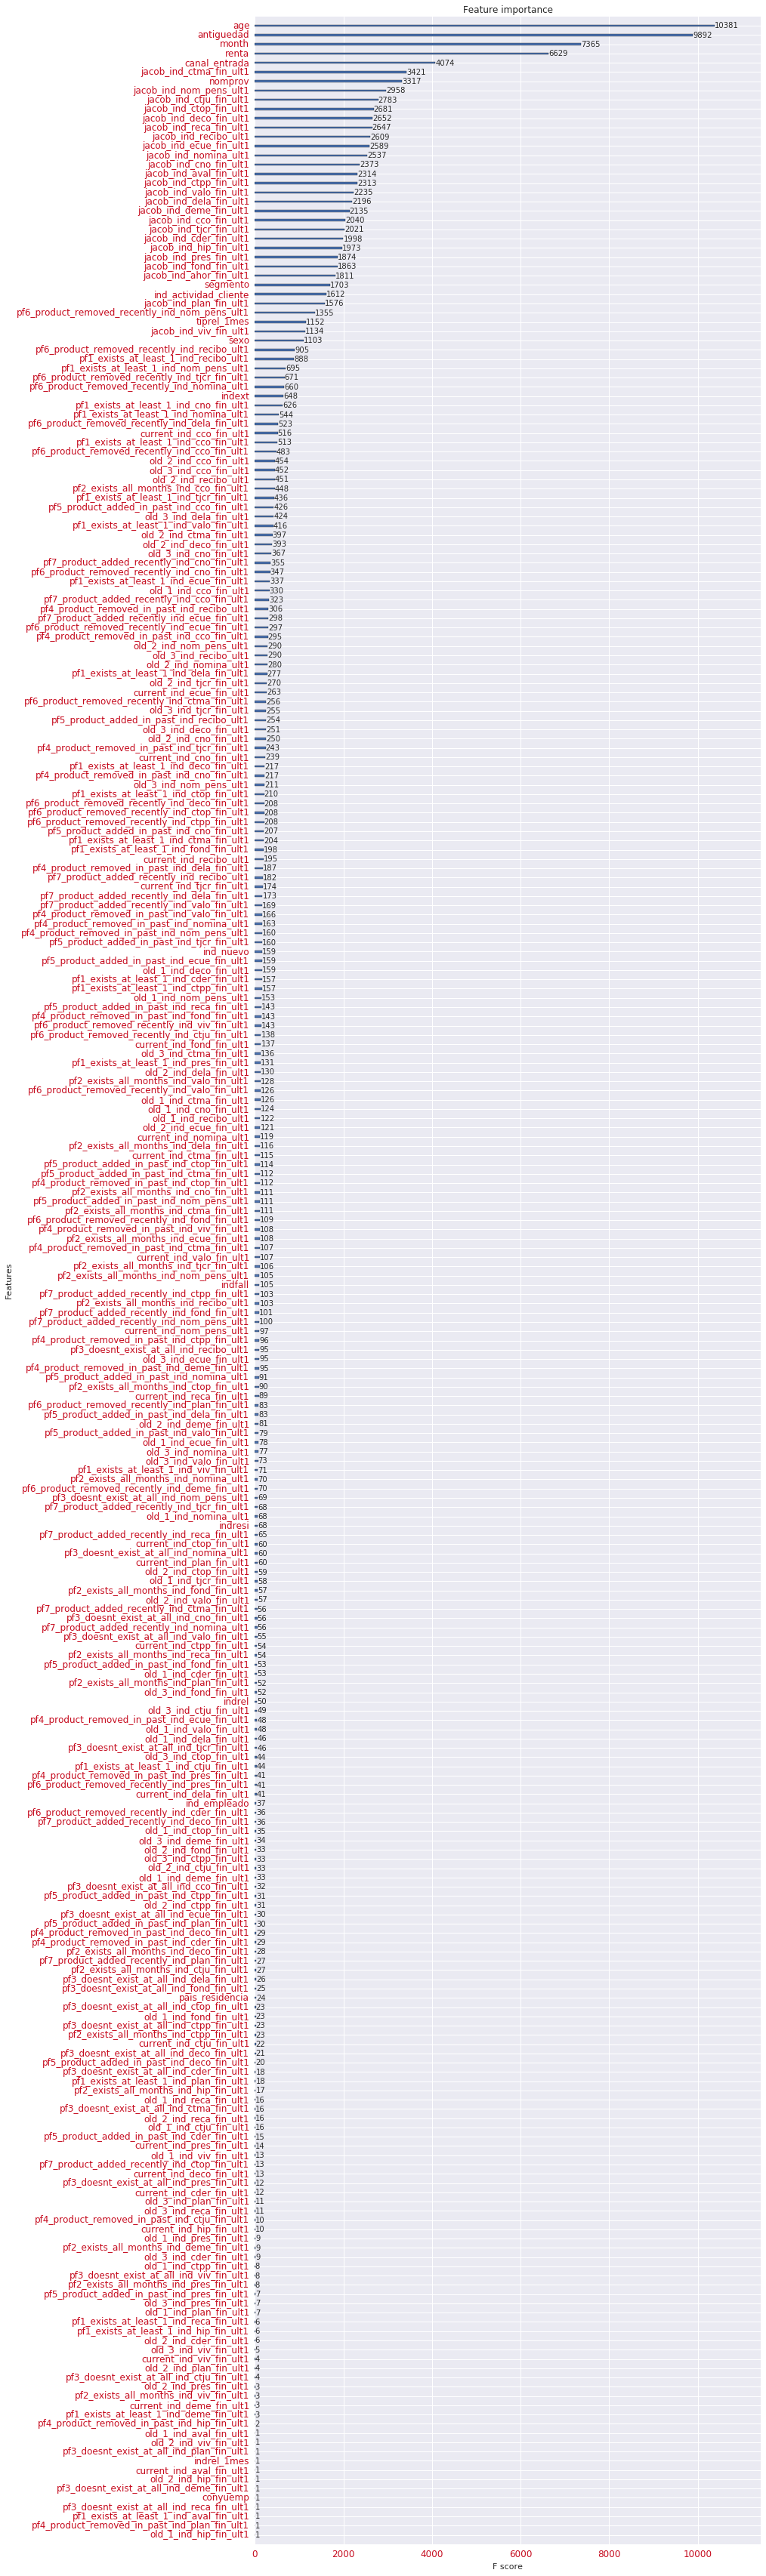

time: 5.21 s


In [12]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

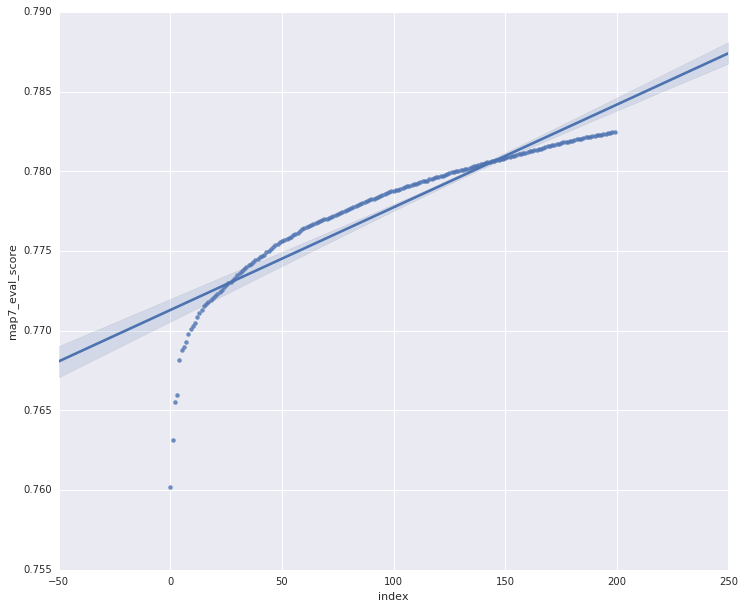

time: 1.11 s


In [13]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [14]:
xgb_model.save_model('data/16.xgboost_model_save.xgb')
make_submission('data/16.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/16.xgboost_model_save.xgb.zip
uploading to s3 done
time: 917 ms


In [15]:
description, test1 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2
gc.collect()

95673

time: 1min 51s


In [16]:
test.shape

(929615, 388)

time: 2.17 ms


In [17]:
jacob_test = pickle.load(open('data/15.Jacobian_similarity_features.test_data', 'rb'))

time: 7.3 s


In [19]:
test.head()

,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
ncodpers,,,,,,,,,,,,,,,,,,,,,
869505,3,36,0,26,0.0,75.0,1.0,0,0,1,...,1.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,3.0,6
1477437,3,36,0,22,0.0,8.0,1.0,0,0,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
1533309,3,36,0,52,1.0,4.0,1.0,0,1,1,...,0.0,3.0,36.0,1.0,1.0,0.0,2.0,0.0,14.0,6
1484304,3,36,0,25,0.0,8.0,1.0,0,1,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
1484306,3,36,0,22,0.0,8.0,1.0,0,1,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6


time: 24.9 ms


In [18]:
jacob_test.head()

,jacob_ind_ahor_fin_ult1,cosine_ind_ahor_fin_ult1,jacob_ind_aval_fin_ult1,cosine_ind_aval_fin_ult1,jacob_ind_cco_fin_ult1,cosine_ind_cco_fin_ult1,jacob_ind_cder_fin_ult1,cosine_ind_cder_fin_ult1,jacob_ind_cno_fin_ult1,cosine_ind_cno_fin_ult1,...,jacob_ind_valo_fin_ult1,cosine_ind_valo_fin_ult1,jacob_ind_viv_fin_ult1,cosine_ind_viv_fin_ult1,jacob_ind_nomina_ult1,cosine_ind_nomina_ult1,jacob_ind_nom_pens_ult1,cosine_ind_nom_pens_ult1,jacob_ind_recibo_ult1,cosine_ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15889,0.000884,0.021912,0.000769,0.033934,0.0,0.0,0.006847,0.075836,0.415941,0.796417,...,0.000000,0.000000,0.043409,0.182025,0.414067,0.755225,0.434003,0.794059,0.497496,1.088009
1170544,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507
1170545,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507
1170547,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507
1170548,0.000082,0.006950,0.000014,0.002669,0.0,0.0,0.000409,0.017265,0.011386,0.035273,...,0.026649,0.137963,0.003207,0.044278,0.011827,0.043281,0.012634,0.044497,0.105950,0.256507


time: 27 ms


In [22]:
test.loc[15889]

ind_empleado                      2.000000
pais_residencia                  36.000000
sexo                              2.000000
age                              56.000000
ind_nuevo                         0.000000
antiguedad                      256.000000
indrel                            1.000000
indrel_1mes                       0.000000
tiprel_1mes                       0.000000
indresi                           1.000000
indext                            0.000000
conyuemp                          0.000000
canal_entrada                    24.000000
indfall                           0.000000
nomprov                          30.000000
ind_actividad_cliente             1.000000
renta                        326124.900000
segmento                          0.000000
current_ind_ahor_fin_ult1         0.000000
current_ind_aval_fin_ult1         0.000000
current_ind_cco_fin_ult1          1.000000
current_ind_cder_fin_ult1         0.000000
current_ind_cno_fin_ult1          0.000000
current_ind

time: 1.81 s


In [20]:
for col in ['jacob_'+h for h in HEADER[24:]]:
    test[col] = jacob_test[col]

time: 732 ms


In [21]:
for col in user_attributes:
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
#     del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

time: 5.5 s


In [23]:
print test.shape
print train.shape

(929615, 307)
(441652, 307)
time: 1.24 ms


In [24]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)

time: 1min


In [25]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [13:08<00:00, 1179.41it/s]

time: 13min 11s


In [26]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/16.xgb_trained_on_all_months_only_product_subs_with_jacob_similarity_scores.csv'
description = '16. (feature engineering was done in 13.)\
               xgb model 200 iter trained on all months on added products and more features\
               features generated from last 4 months\
               jacobian similarity scores as features \
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.xgb_trained_on_all_months_only_product_subs_with_jacob_similarity_scores.csv.zip
uploading to s3 done
Uploading submission data/16.xgb_trained_on_all_months_only_product_subs_with_jacob_similarity_scores.csv.zip
Upload done
time: 18.4 s


In [27]:
pickle_description = '16. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.xgb_trained_on_all_months_only_product_subs_with_jacob_similarity_scores.csv.pickle.zip
uploading to s3 done
time: 1min 55s


---
# 16.1 both jacobian and cosine similarity features
---

In [28]:
del test['xgb_preds'], test['added_products']

time: 87 ms


In [29]:
for col in ['cosine_' + h for h in HEADER[24:]]:
    test[col] = jacob_test[col]
    train[col] = jacob_train[col]

time: 730 ms


In [30]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 4.21 s


In [31]:
print train.shape
print test.shape

(441652, 331)
(929615, 331)
time: 1.15 ms


In [33]:
def test_train_split_wt(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

time: 7.58 ms


In [34]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 400
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 331) (22082, 3)
(419570, 331) (419570, 3)
time: 5.44 s


In [37]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759656	cv-MAP@7:0.760167
[1]	train-MAP@7:0.763122	cv-MAP@7:0.764741
[2]	train-MAP@7:0.763884	cv-MAP@7:0.765012
[3]	train-MAP@7:0.767073	cv-MAP@7:0.768273
[4]	train-MAP@7:0.767593	cv-MAP@7:0.768545
[5]	train-MAP@7:0.768053	cv-MAP@7:0.769269
[6]	train-MAP@7:0.768484	cv-MAP@7:0.768726
[7]	train-MAP@7:0.768732	cv-MAP@7:0.768635
[8]	train-MAP@7:0.769116	cv-MAP@7:0.768726
[9]	train-MAP@7:0.769361	cv-MAP@7:0.768545
[10]	train-MAP@7:0.769776	cv-MAP@7:0.769133
[11]	train-MAP@7:0.770205	cv-MAP@7:0.768952
[12]	train-MAP@7:0.770498	cv-MAP@7:0.769043
[13]	train-MAP@7:0.770741	cv-MAP@7:0.769269
[14]	train-MAP@7:0.770987	cv-MAP@7:0.769858
[15]	train-MAP@7:0.771242	cv-MAP@7:0.77022
[16]	train-MAP@7:0.771313	cv-MAP@7:0.77022
[17]	train-MAP@7:0.771621	cv-MAP@7:0.770265
[18]	train-MAP@7:0.771876	cv-MAP@7:0.770537
[19]	train-MAP@7:0.772079	cv-MAP@7:0.770899
[20]	train-MAP@7:0.772219	cv-MAP@7:0.77099
[21]	train-MAP@7:0.772353	cv-MAP@7:0.771081
[22]	train-MAP@7:0.772508	cv-MAP@7:0.771216
[

KeyboardInterrupt: 

time: 1h 5min 40s


In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

In [40]:
optimal_n = 100

time: 1.3 ms


In [39]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 4.15 s


In [41]:
# optimal n in this case was found to be 116
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.757347	cv-MAP@7:0.758718
[1]	train-MAP@7:0.763036	cv-MAP@7:0.765193
[2]	train-MAP@7:0.766301	cv-MAP@7:0.769043
[3]	train-MAP@7:0.766706	cv-MAP@7:0.769496
[4]	train-MAP@7:0.767321	cv-MAP@7:0.770084
[5]	train-MAP@7:0.767803	cv-MAP@7:0.770537
[6]	train-MAP@7:0.768077	cv-MAP@7:0.770492
[7]	train-MAP@7:0.768599	cv-MAP@7:0.771262
[8]	train-MAP@7:0.768921	cv-MAP@7:0.771805
[9]	train-MAP@7:0.769624	cv-MAP@7:0.77185
[10]	train-MAP@7:0.769981	cv-MAP@7:0.77253
[11]	train-MAP@7:0.770131	cv-MAP@7:0.772666
[12]	train-MAP@7:0.770522	cv-MAP@7:0.773028
[13]	train-MAP@7:0.77071	cv-MAP@7:0.773028
[14]	train-MAP@7:0.771004	cv-MAP@7:0.773481
[15]	train-MAP@7:0.771294	cv-MAP@7:0.773345
[16]	train-MAP@7:0.771437	cv-MAP@7:0.774205
[17]	train-MAP@7:0.771533	cv-MAP@7:0.774251
[18]	train-MAP@7:0.771714	cv-MAP@7:0.774794
[19]	train-MAP@7:0.771912	cv-MAP@7:0.774749
[20]	train-MAP@7:0.772038	cv-MAP@7:0.774477
[21]	train-MAP@7:0.772183	cv-MAP@7:0.774703
[22]	train-MAP@7:0.772329	cv-MAP@7:0.774703
[

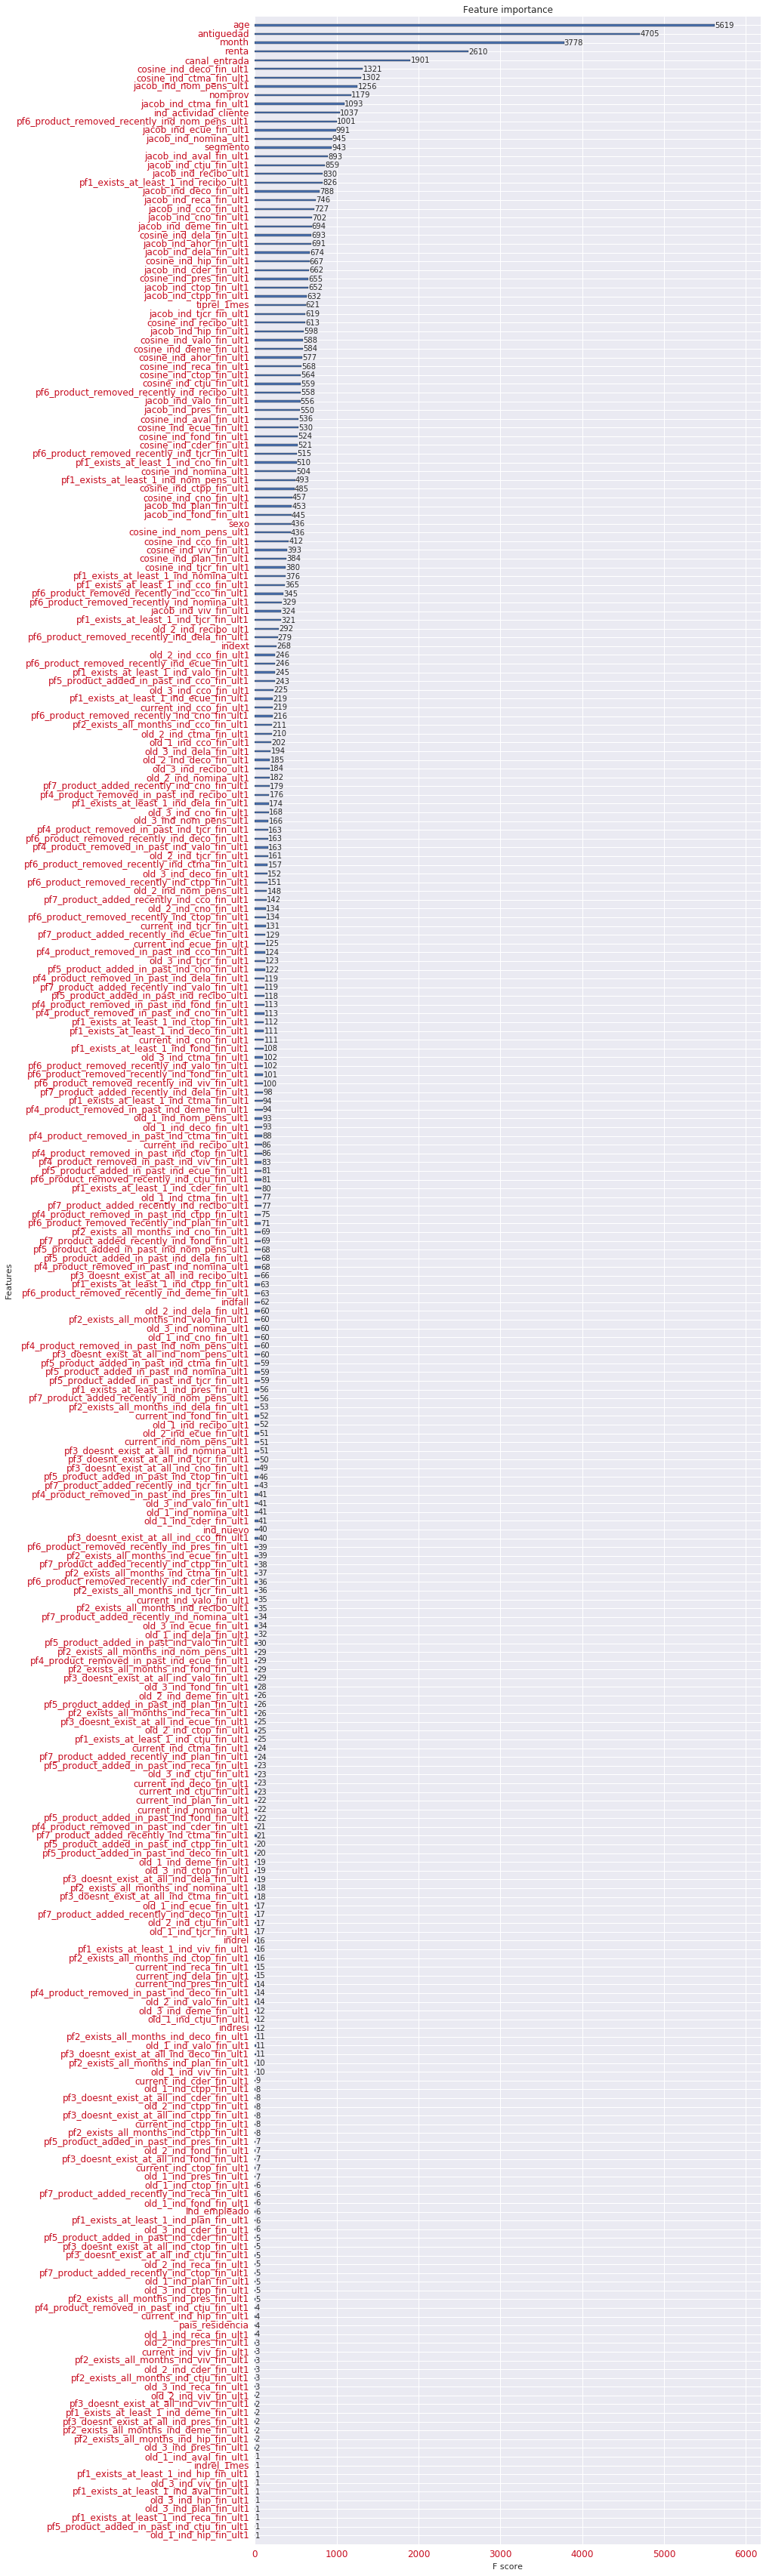

time: 5.1 s


In [42]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

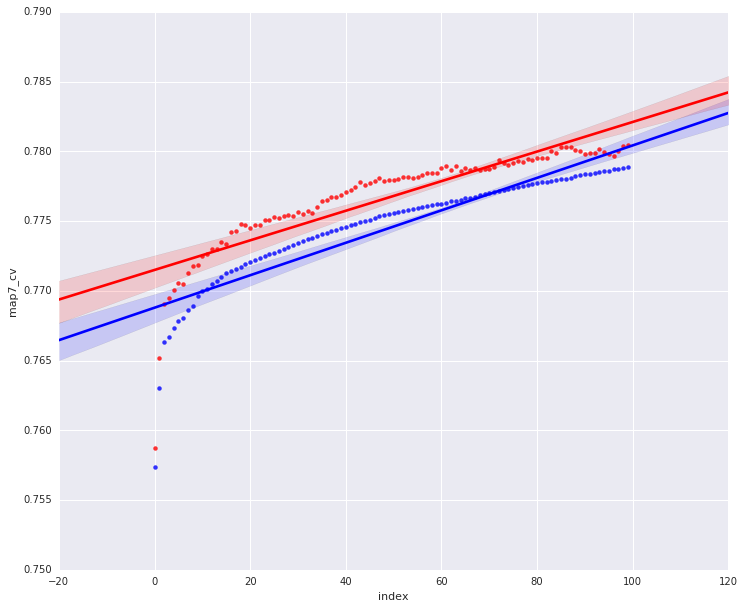

time: 556 ms


In [43]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [44]:
main_xgb_model.save_model('data/16.1.xgboost_model_save.xgb')
make_submission('data/16.1.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/16.1.xgboost_model_save.xgb.zip
uploading to s3 done
time: 1.34 s


In [45]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 30.1 s


In [46]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [13:55<00:00, 1113.20it/s]

time: 13min 58s


In [47]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/16.1.xgb_trained_on_all_months_jacob_cosine_features_only_product_lag_features_optimal_n.csv'
description = '16.1 11 submisssion with jacobian and cosian similaarites with optimal n' + str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.1.xgb_trained_on_all_months_jacob_cosine_features_only_product_lag_features_optimal_n.csv.zip
uploading to s3 done
Uploading submission data/16.1.xgb_trained_on_all_months_jacob_cosine_features_only_product_lag_features_optimal_n.csv.zip
Upload done
time: 18.6 s


In [48]:
pickle_description = '16.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.1.xgb_trained_on_all_months_jacob_cosine_features_only_product_lag_features_optimal_n.csv.pickle.zip
uploading to s3 done
time: 1min 8s


---
# 16.2 Do just cosine features
---

In [49]:
del test['xgb_preds'], test['added_products']

time: 91.5 ms


In [50]:
for col in ['jacob_' + h for h in HEADER[24:]]:
    del test[col]
    del train[col]

time: 11.7 s


In [51]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 300
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 307) (22082, 3)
(419570, 307) (419570, 3)
time: 4.95 s


In [52]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.757282	cv-MAP@7:0.756
[1]	train-MAP@7:0.762171	cv-MAP@7:0.760076
[2]	train-MAP@7:0.766246	cv-MAP@7:0.764333
[3]	train-MAP@7:0.767123	cv-MAP@7:0.76465
[4]	train-MAP@7:0.767614	cv-MAP@7:0.764967
[5]	train-MAP@7:0.768008	cv-MAP@7:0.765329
[6]	train-MAP@7:0.76858	cv-MAP@7:0.765918
[7]	train-MAP@7:0.768832	cv-MAP@7:0.766235
[8]	train-MAP@7:0.768928	cv-MAP@7:0.766461
[9]	train-MAP@7:0.769538	cv-MAP@7:0.766643
[10]	train-MAP@7:0.769855	cv-MAP@7:0.767005
[11]	train-MAP@7:0.770158	cv-MAP@7:0.767367
[12]	train-MAP@7:0.770572	cv-MAP@7:0.767503
[13]	train-MAP@7:0.770792	cv-MAP@7:0.767911
[14]	train-MAP@7:0.771039	cv-MAP@7:0.767911
[15]	train-MAP@7:0.771271	cv-MAP@7:0.768137
[16]	train-MAP@7:0.771426	cv-MAP@7:0.768228
[17]	train-MAP@7:0.771597	cv-MAP@7:0.768318
[18]	train-MAP@7:0.771735	cv-MAP@7:0.768454
[19]	train-MAP@7:0.771905	cv-MAP@7:0.76859
[20]	train-MAP@7:0.77204	cv-MAP@7:0.768635
[21]	train-MAP@7:0.772176	cv-MAP@7:0.768862
[22]	train-MAP@7:0.77235	cv-MAP@7:0.768771
[23]	t

KeyboardInterrupt: 

time: 1h 3min 46s


In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

In [53]:
optimal_n = 114

time: 925 µs


In [54]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 4 s


In [55]:
# optimal n in this case was found to be 116
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759671	cv-MAP@7:0.760393
[1]	train-MAP@7:0.763119	cv-MAP@7:0.763744
[2]	train-MAP@7:0.766072	cv-MAP@7:0.766824
[3]	train-MAP@7:0.767107	cv-MAP@7:0.768228
[4]	train-MAP@7:0.767207	cv-MAP@7:0.769133
[5]	train-MAP@7:0.767846	cv-MAP@7:0.769948
[6]	train-MAP@7:0.768077	cv-MAP@7:0.769948
[7]	train-MAP@7:0.76836	cv-MAP@7:0.770447
[8]	train-MAP@7:0.768787	cv-MAP@7:0.770899
[9]	train-MAP@7:0.769357	cv-MAP@7:0.771035
[10]	train-MAP@7:0.769535	cv-MAP@7:0.771579
[11]	train-MAP@7:0.769864	cv-MAP@7:0.771805
[12]	train-MAP@7:0.770191	cv-MAP@7:0.772122
[13]	train-MAP@7:0.770503	cv-MAP@7:0.772167
[14]	train-MAP@7:0.770849	cv-MAP@7:0.772801
[15]	train-MAP@7:0.771037	cv-MAP@7:0.773028
[16]	train-MAP@7:0.771206	cv-MAP@7:0.773209
[17]	train-MAP@7:0.771397	cv-MAP@7:0.773073
[18]	train-MAP@7:0.771616	cv-MAP@7:0.773254
[19]	train-MAP@7:0.771826	cv-MAP@7:0.773481
[20]	train-MAP@7:0.772002	cv-MAP@7:0.773526
[21]	train-MAP@7:0.772164	cv-MAP@7:0.773254
[22]	train-MAP@7:0.772315	cv-MAP@7:0.773617

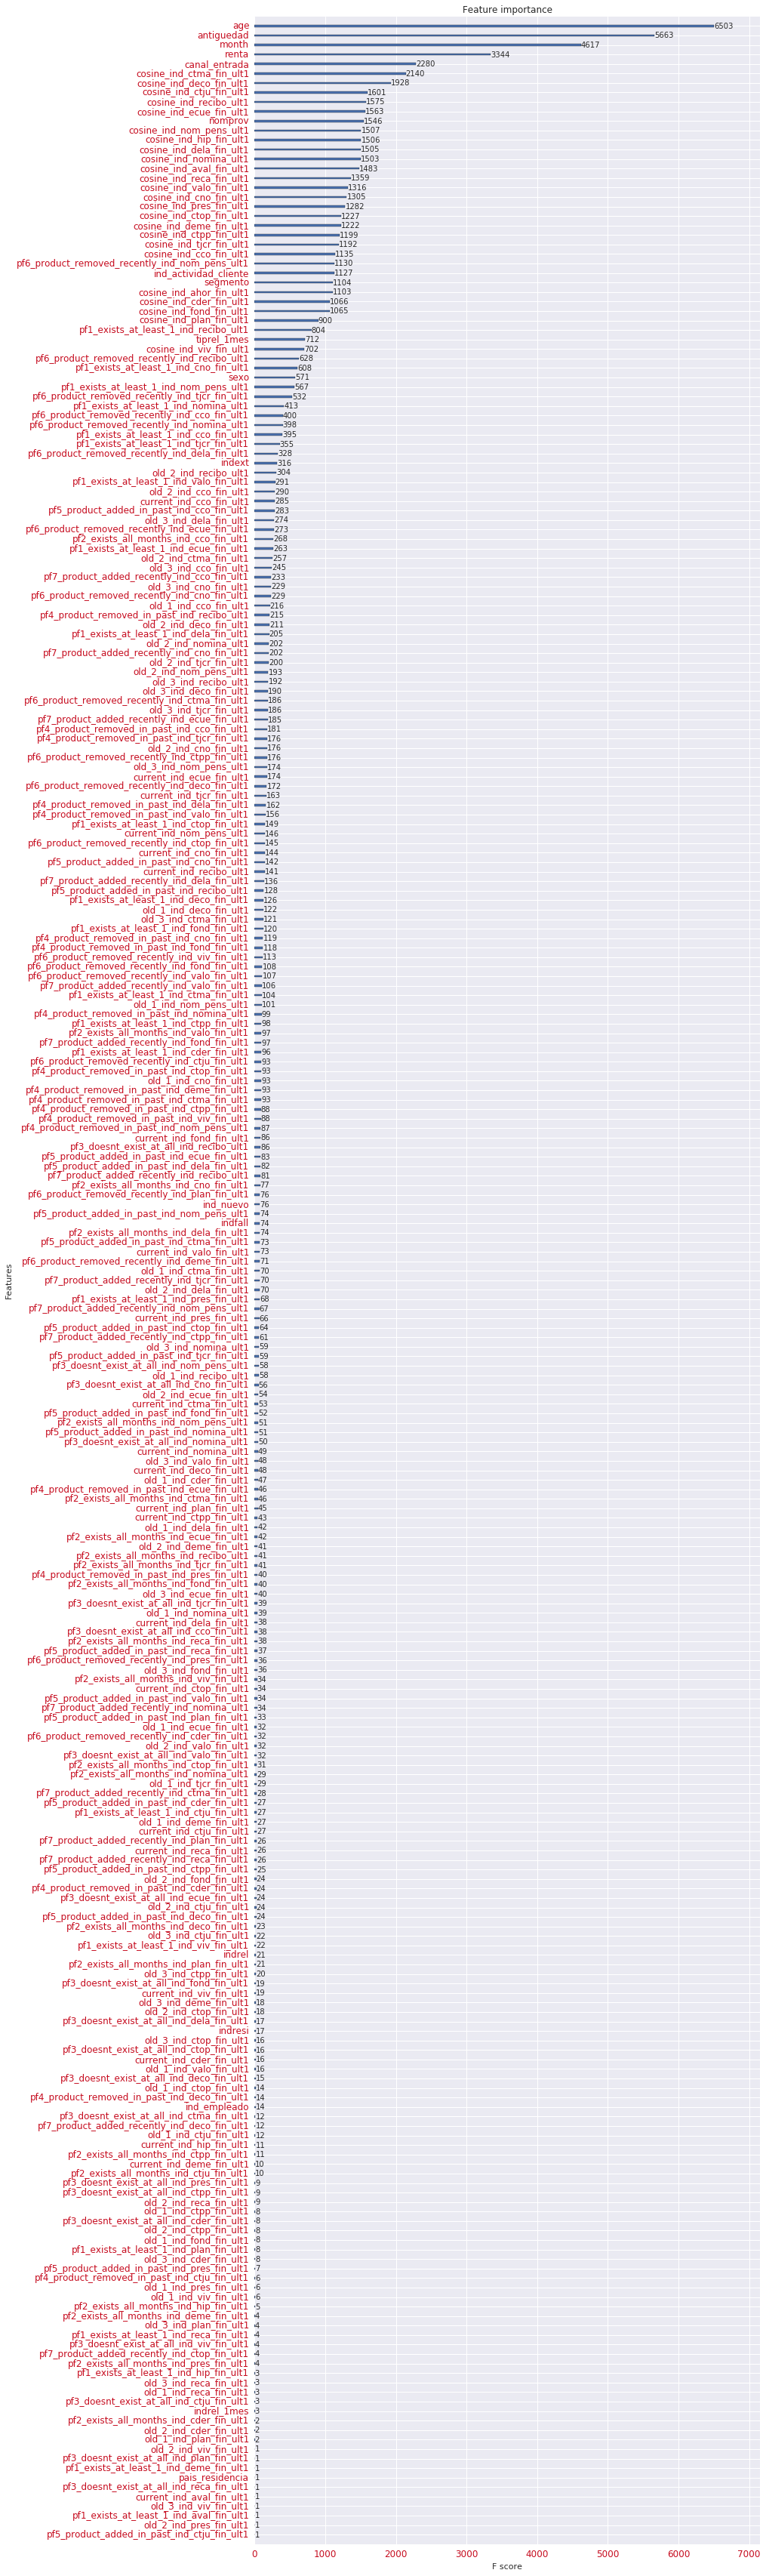

time: 5.03 s


In [56]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

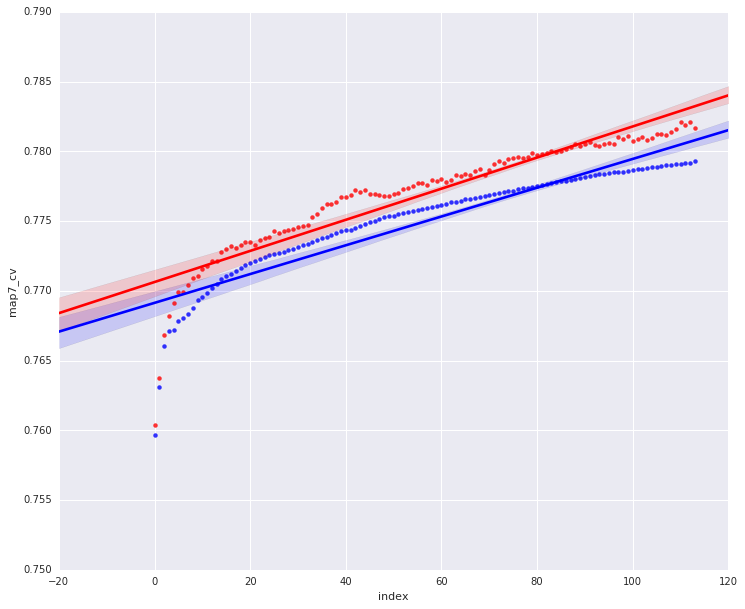

time: 402 ms


In [57]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [58]:
main_xgb_model.save_model('data/16.2.xgboost_model_save.xgb')
make_submission('data/16.2.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/16.2.xgboost_model_save.xgb.zip
uploading to s3 done
time: 678 ms


In [59]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 32.4 s


In [60]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [13:21<00:00, 1160.06it/s]

time: 13min 24s


In [61]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/16.2.xgb_trained_on_all_months_cosine_features_only_product_lag_features_optimal_n.csv'
description = '16.2 11 submisssion with cosian similaarites with optimal n' + str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.2.xgb_trained_on_all_months_cosine_features_only_product_lag_features_optimal_n.csv.zip
uploading to s3 done
Uploading submission data/16.2.xgb_trained_on_all_months_cosine_features_only_product_lag_features_optimal_n.csv.zip
Upload done
time: 26.2 s


In [62]:
pickle_description = '16.2 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.2.xgb_trained_on_all_months_cosine_features_only_product_lag_features_optimal_n.csv.pickle.zip
uploading to s3 done
time: 1min 29s


---
# 16.3 remove old raw features, just change features of subs, and jacobian
---

In [17]:
description, train, added_products, label_encoder, encoders = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/train_data.train_data', 'rb'))

jacob_train = pickle.load(open('data/15.Jacobian_similarity_features.train_data', 'rb'))

user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
#     del test['uf1_changed_recently_' + col], test['u

for col in ['jacob_'+h for h in HEADER[24:]]:
    train[col] = jacob_train[col]

description, test1 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2
gc.collect()


jacob_test = pickle.load(open('data/15.Jacobian_similarity_features.test_data', 'rb'))

for col in ['jacob_'+h for h in HEADER[24:]]:
    test[col] = jacob_test[col]

for col in user_attributes:
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
#     del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

time: 2min 17s


In [25]:
for col in HEADER[24:]:
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col]
    del train['old_1_' + col], train['old_2_' + col], train['old_3_' + col]

time: 11.7 s


In [28]:
old_cols = filter(lambda x: x.count('jacob') != 0, list(train.columns))

time: 1.34 ms


In [30]:
print train.shape

(441652, 235)
time: 993 µs


In [35]:
def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

time: 7.47 ms


In [33]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 300
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 235) (22082, 3)
(419570, 235) (419570, 3)
time: 4.26 s


In [36]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.760092	cv-MAP@7:0.758853
[1]	train-MAP@7:0.762311	cv-MAP@7:0.76062
[2]	train-MAP@7:0.763505	cv-MAP@7:0.761254
[3]	train-MAP@7:0.765293	cv-MAP@7:0.762703
[4]	train-MAP@7:0.76756	cv-MAP@7:0.764424
[5]	train-MAP@7:0.767989	cv-MAP@7:0.764288
[6]	train-MAP@7:0.768091	cv-MAP@7:0.764605
[7]	train-MAP@7:0.768844	cv-MAP@7:0.76551
[8]	train-MAP@7:0.769264	cv-MAP@7:0.765782
[9]	train-MAP@7:0.769597	cv-MAP@7:0.765827
[10]	train-MAP@7:0.769743	cv-MAP@7:0.76619
[11]	train-MAP@7:0.770212	cv-MAP@7:0.766733
[12]	train-MAP@7:0.770444	cv-MAP@7:0.766824
[13]	train-MAP@7:0.770591	cv-MAP@7:0.766824
[14]	train-MAP@7:0.770782	cv-MAP@7:0.766824
[15]	train-MAP@7:0.771106	cv-MAP@7:0.767231
[16]	train-MAP@7:0.77128	cv-MAP@7:0.767095
[17]	train-MAP@7:0.771456	cv-MAP@7:0.767367
[18]	train-MAP@7:0.771638	cv-MAP@7:0.767639
[19]	train-MAP@7:0.771816	cv-MAP@7:0.767594
[20]	train-MAP@7:0.771919	cv-MAP@7:0.767639
[21]	train-MAP@7:0.772076	cv-MAP@7:0.767729
[22]	train-MAP@7:0.772162	cv-MAP@7:0.767548
[23

KeyboardInterrupt: 

time: 44min 9s


In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

In [37]:
optimal_n = 100

time: 953 µs


In [38]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 2.99 s


In [39]:
# optimal n in this case was found to be 116
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759601	cv-MAP@7:0.761706
[1]	train-MAP@7:0.761768	cv-MAP@7:0.761842
[2]	train-MAP@7:0.762676	cv-MAP@7:0.762657
[3]	train-MAP@7:0.766904	cv-MAP@7:0.766869
[4]	train-MAP@7:0.7675	cv-MAP@7:0.767503
[5]	train-MAP@7:0.767893	cv-MAP@7:0.767141
[6]	train-MAP@7:0.768339	cv-MAP@7:0.767911
[7]	train-MAP@7:0.768646	cv-MAP@7:0.768182
[8]	train-MAP@7:0.76903	cv-MAP@7:0.768545
[9]	train-MAP@7:0.769471	cv-MAP@7:0.769043
[10]	train-MAP@7:0.769914	cv-MAP@7:0.769586
[11]	train-MAP@7:0.77022	cv-MAP@7:0.769722
[12]	train-MAP@7:0.770572	cv-MAP@7:0.769767
[13]	train-MAP@7:0.770734	cv-MAP@7:0.769858
[14]	train-MAP@7:0.770837	cv-MAP@7:0.77022
[15]	train-MAP@7:0.771004	cv-MAP@7:0.770854
[16]	train-MAP@7:0.771161	cv-MAP@7:0.77099
[17]	train-MAP@7:0.771333	cv-MAP@7:0.771171
[18]	train-MAP@7:0.771478	cv-MAP@7:0.771307
[19]	train-MAP@7:0.771678	cv-MAP@7:0.771488
[20]	train-MAP@7:0.771788	cv-MAP@7:0.77176
[21]	train-MAP@7:0.771876	cv-MAP@7:0.771624
[22]	train-MAP@7:0.772005	cv-MAP@7:0.771579
[23]	

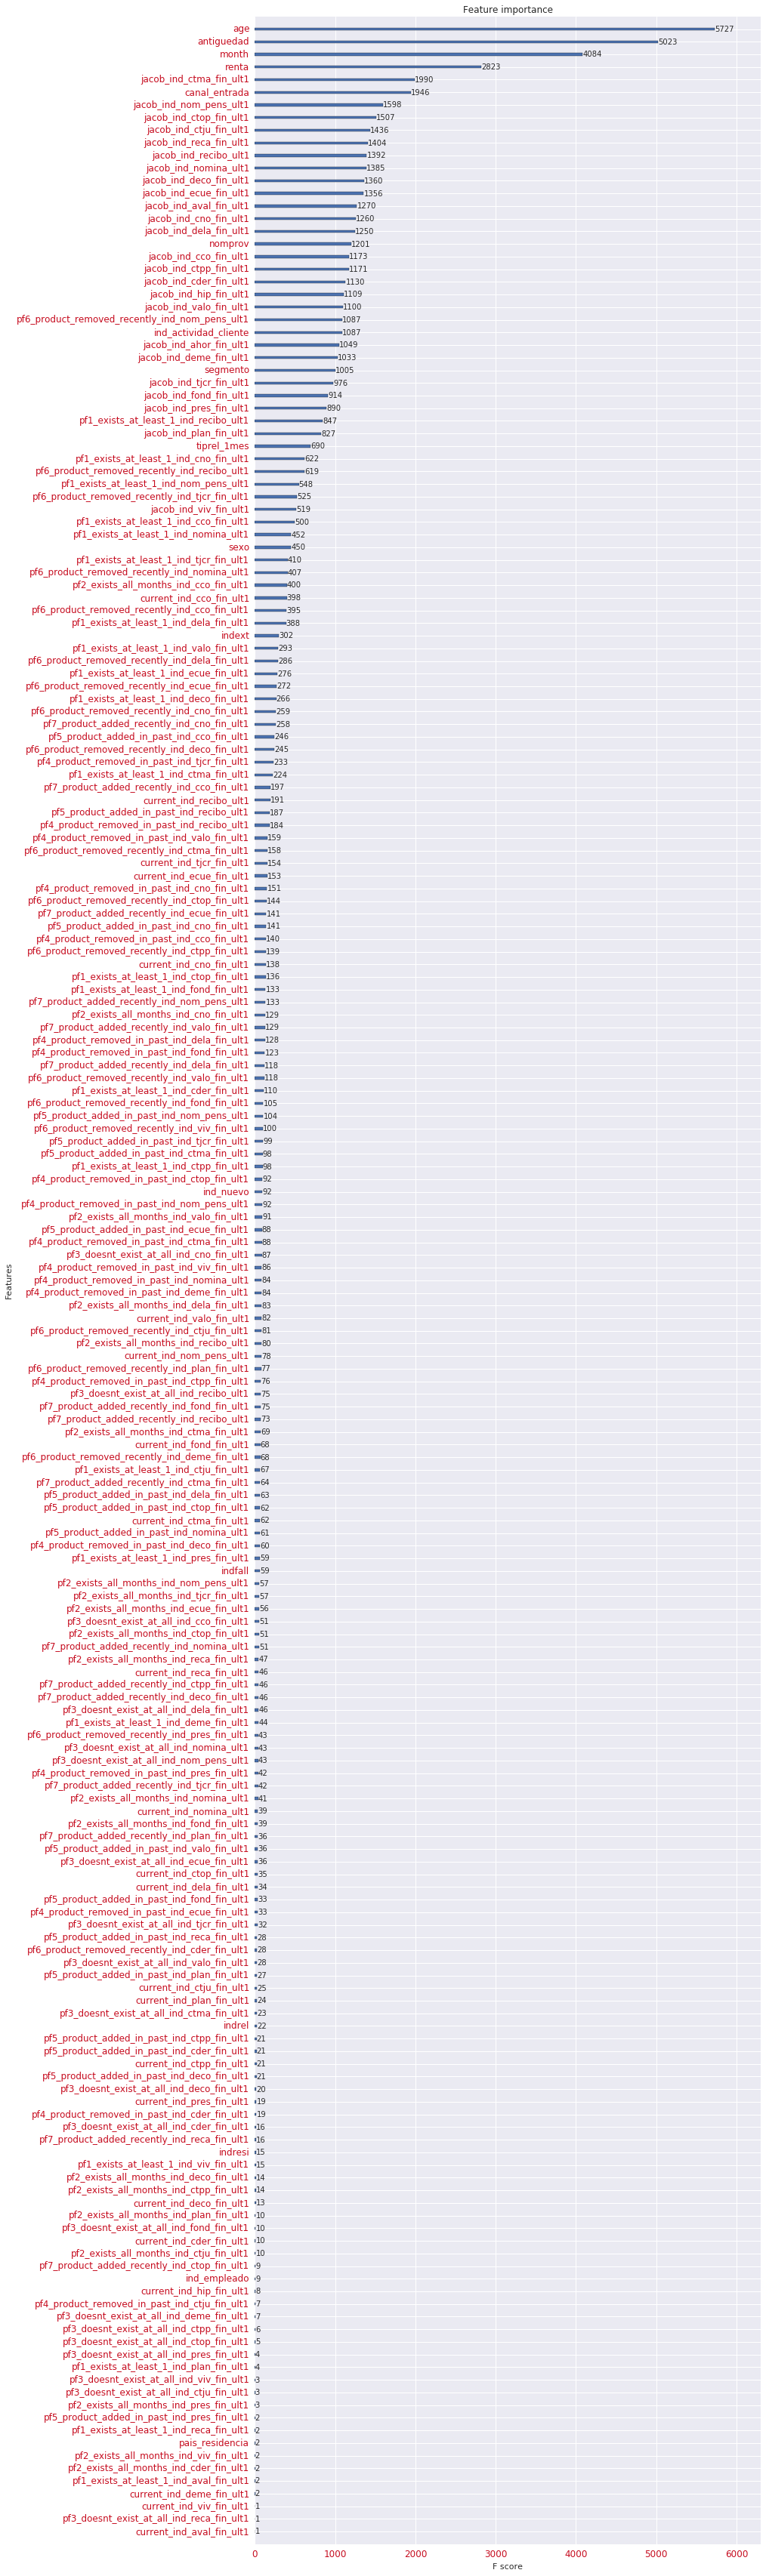

time: 3.95 s


In [40]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

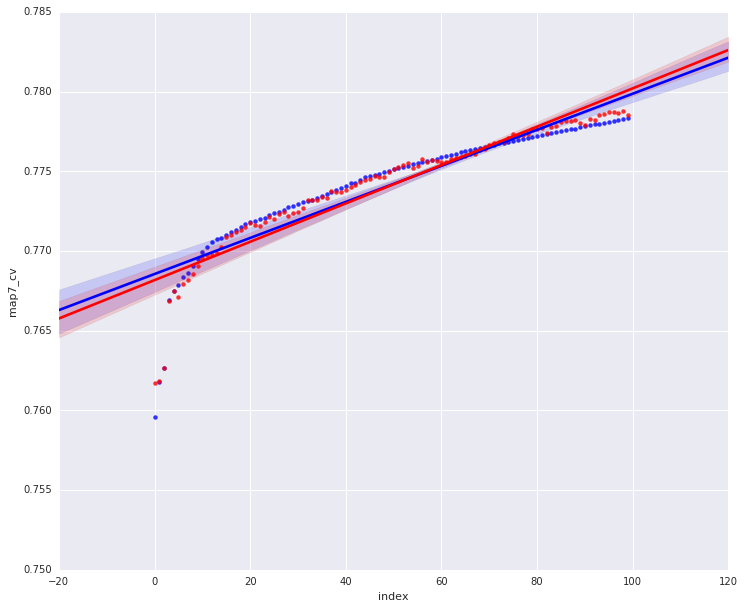

time: 571 ms


In [41]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [42]:
main_xgb_model.save_model('data/16.3.xgboost_model_save.xgb')
make_submission('data/16.3.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/16.3.xgboost_model_save.xgb.zip
uploading to s3 done
time: 470 ms


In [43]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 27.9 s


In [44]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:58<00:00, 1293.32it/s]

time: 12min 2s


In [45]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/16.3.xgb_trained_on_all_months_jacobian_change_subs.csv'
description = '16.3 11 submission with jacob similarities, change subs features' + str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.3.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
uploading to s3 done
Uploading submission data/16.3.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
Upload done
time: 15.4 s


In [46]:
pickle_description = '16.3 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/16.3.xgb_trained_on_all_months_jacobian_change_subs.csv.pickle.zip
uploading to s3 done
time: 1min 19s
